# Part 1:
## Shortest path to all mutants

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO 
import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics.pairwise import manhattan_distances

fastas = SeqIO.parse('BM3sMSA.txt', 'fasta')

df =  pd.DataFrame([list(x.seq) for x in fastas])
fastas = SeqIO.parse('BM3sMSA.txt', 'fasta')

names = pd.Series([x.id for x in fastas])
names = names.str.split(':',expand =True)[0].drop_duplicates()

df = df.loc[:,df.apply(pd.Series.nunique) != 1]
df = df.loc[names.index.values]
df = df.set_index(names)
df = df[df.columns[df.columns<450]]
df = df[df.columns[df.columns>0]]


data = df

encoder = LabelEncoder()

for column in data:
    data[column] = encoder.fit_transform(data[column])
    
#OneHot
OneHotEncoder = OneHotEncoder()
data = OneHotEncoder.fit_transform(data)


distances = pd.DataFrame(manhattan_distances(data.toarray()))
distances.columns= names
distances = distances.set_index(names)

fig, ax = plt.subplots(figsize=(15,5))
plt.set_cmap('viridis')
plt.imshow(distances)
plt.yticks(np.arange(len(distances.columns.values)))
plt.xticks(np.arange(len(distances.columns.values)+1))
ax.set_xticklabels(list(distances.columns.values),
                   size = 8, rotation = 90, 
                   color = '0.2')
ax.set_yticklabels(distances.columns.values,
                   y = distances.columns.values,
                   size = 8,
                  color = '0.2')
plt.colorbar(label = 'Manhattan Distance')
plt.title('Manhattan distance matrix for \nP450 BM3 FASTA sequences in the PDB')
plt.show()

<Figure size 1500x500 with 2 Axes>

In [2]:
nodedf = df.loc[pd.Series(G.nodes())]
nodedf.loc[:,nodedf.apply(pd.Series.nunique) != 1].to_clipboard(sep = '\t')

NameError: name 'G' is not defined

## Distance matrix to graph

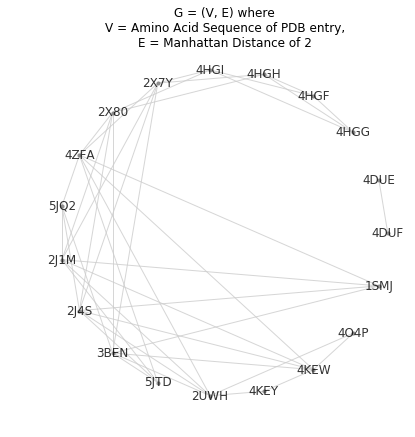

In [7]:
import networkx as nx

distanceE = distances[distances  == 2].rename_axis('Source').replace({0:'NaN'})\
  .reset_index()\
  .melt('Source', value_name='Weight', var_name='Target')\
  .query('Source != Target')\
  .reset_index(drop=True).dropna()

G=nx.from_pandas_edgelist(distanceE,
                         source = 'Source',
                          target = 'Target',
                          edge_attr = 'Weight')
plt.figure(figsize = (5,5))
nx.draw_circular(G, 
        node_size= 10,
       alpha = 0.8,
        edge_color = '0.8',
                 node_color='0.5',
       cmap =plt.cm.viridis,
                with_labels  = True)

plt.axis('off')
plt.title('G = (V, E) where\nV = Amino Acid Sequence of PDB entry,\nE = Manhattan Distance of 2')

plt.draw()
plt.show()

## Shortest path from 4KEY to all others

In [8]:
paths = nx.shortest_path(G,'4KEY')

pathsdf = pd.DataFrame()
for i in paths:
    pathsdf = pathsdf.append([paths[i]]).reset_index(drop=True)
    
pairs = pd.concat([pathsdf[0],pathsdf[1]],
         axis = 1, join = 'inner')

for i in range(1,5):
    x = pd.concat([pathsdf[i],pathsdf[i+1]],
             axis = 1, join = 'inner')
    x.columns = [0,1]
    pairs = pairs.append(x)
pairs = pairs.dropna()
pairs = pairs.drop_duplicates()
pairs.columns=['Source','Target']
pairs

,Source,Target
1,4KEY,2UWH
2,4KEY,4KEW
3,2UWH,4O4P
4,2UWH,4ZFA
5,2UWH,2J1M
6,2UWH,2J4S
7,2UWH,3BEN
8,4ZFA,5JQ2
9,4ZFA,5JTD
10,4ZFA,2X7Y


# Part 2:
## Primers

In [9]:
codontable = {
    'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
    'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
    'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
    'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
    'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
    'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
    'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
    'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
    'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
    'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
    'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
    'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
    'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
    'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
    'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
    'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W',
    }

In [35]:
from Bio.SeqUtils import GC
from Bio.SeqUtils import MeltingTemp as mt
from Bio import Seq

def getcodon(template,target):
    codon = df.loc[[template,target]].loc[:,df.loc[[template,target]].apply(pd.Series.nunique) != 1].loc[target]
    return codon.values#[0]
def mutationcodon(x):
    arr = np.array([])

    for i,j in codontable.items():
        if j == x:
            arr = np.append(arr,i)
    return arr[0]  ##first in list because I'm basic

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

def makeprimer(template, target, Plasmid):
    point = df.loc[[template,target]].loc[:,df.loc[[template,target]].apply(pd.Series.nunique) != 1].columns.values-1
    ##this locates the mismatch  and gets the amino acid number
    pointdna = (point[0]*3)+3
    ### position on DNA CDS
     ###Get as close to 65 as possible
    arr = np.array([]) # brute force - make array of primer scores
    for length in range(6,50):
        pointdna = (point[0]*3)+3
        primer = Plasmid[pointdna:pointdna + length]
        arr = np.append(arr,mt.Tm_NN(primer))
        #tailGC = (GC(primer[-3:-1])/100)**2 ##just in case there's one GC at the end, then score is 75%  
        #score = 65/mt.Tm_NN(primer)#*tailGC #score is closeness to 65 x GC conent of last two
                #arr = np.append(arr,[score])
    primer = 10+find_nearest(arr,65)[1]
    primer = Plasmid[pointdna:pointdna + length]
    return str(primer)
i=16
x = makeprimer(rxns['Source'][i],rxns['Target'][i], Plasmid)
print(x)

atgaacaagctgcagcgagcaaatccagacgacccagcttatgatgaaa


In [32]:
fastas = SeqIO.parse('BM3sMSA.txt', 'fasta')

df =  pd.DataFrame([list(x.seq) for x in fastas])
fastas = SeqIO.parse('BM3sMSA.txt', 'fasta')

names = pd.Series([x.id for x in fastas])
names = names.str.split(':',expand =True)[0].drop_duplicates()

df = df.loc[:,df.apply(pd.Series.nunique) != 1]
df = df.loc[names.index.values]
df = df.set_index(names)
df = df[df.columns[df.columns<450]]
df = df[df.columns[df.columns>0]]

### have to reimport because the labelencoder overwrote the original sequences

#Plasmid = open('Codonoptimised BM3a82ff87v.txt', 'r')
Plasmid = open('P450BM34KEYcds.txt', 'r')
Plasmid = Plasmid.read().lower().replace(' ','')
Plasmid = Seq.Seq(Plasmid)
Plasmid = Plasmid[6:len(Plasmid.translate()[0:450])*3]
        
### also importing the CDS of my plasmid

rxns = pairs#distanceE.reset_index(drop=True).drop('Weight', axis = 1)
rxns['Substitute to:'] = [getcodon(rxns.loc[i,'Source'],rxns.loc[i,'Target']) for i in rxns.index]
rxns['newcodon'] = [mutationcodon(i) for i in rxns['Substitute to:']]
rxns['baseprimer'] = [makeprimer(rxns['Source'][i],rxns['Target'][i], Plasmid) for i in rxns.index]
rxns['Tm/°C'] = [mt.Tm_NN(i) for i in rxns['baseprimer']]

primersheet = pd.concat([rxns['Source'],
                         rxns['Target'],
                         rxns['newcodon'].str.cat([rxns['baseprimer']]),
          rxns['Tm/°C']],
         axis = 1,
         join = 'inner')
primersheet.columns=['Source','Target','Primer', 'Tm °C']
primersheet = primersheet.drop_duplicates('Target').reset_index(drop=True)

primersheet['GC'] = pd.Series([GC(i) for i in primersheet['Primer']], name = 'GC content (%)')
### add gc cntent

### add % repeats
repeats = []
for j in primersheet.index:
    count = 0
    for i in range(0,len(primersheet['Primer'][j])-1):
        if (primersheet['Primer'][j])[i] == (primersheet['Primer'][j])[i+1]:
            count = count + 1
    repeats.append(count/len(primersheet['Primer'][j])*100)
repeats = pd.Series(repeats, name = '% repeats')
primersheet['% Repeats'] = repeats

C:\Users\MFBX3JE3\Anaconda35\lib\site-packages\Bio\Seq.py:2576: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


In [33]:
rxns

,Source,Target,Substitute to:,newcodon,baseprimer,Tm/°C
1,4KEY,2UWH,[F],TTC,acaagctggacgcatgaaaaaaattggaaaaaagcgcataatatcttac,64.867155
2,4KEY,4KEW,[F],TTC,acaagctggacgcatgaaaaaaattggaaaaaagcgcataatatcttac,64.867155
3,2UWH,4O4P,[V],GTA,acaagctggacgcatgaaaaaaattggaaaaaagcgcataatatcttac,64.867155
4,2UWH,4ZFA,[A],GCA,ggagacgggttagttacaagctggacgcatgaaaaaaattggaaaaaag,66.509353
5,2UWH,2J1M,[A],GCA,ggagacgggttagttacaagctggacgcatgaaaaaaattggaaaaaag,66.509353
6,2UWH,2J4S,[A],GCA,ggagacgggttagttacaagctggacgcatgaaaaaaattggaaaaaag,66.509353
7,2UWH,3BEN,[A],GCA,ggagacgggttagttacaagctggacgcatgaaaaaaattggaaaaaag,66.509353
8,4ZFA,5JQ2,[C],TGC,catgaagcaacgctggtcctaggtatgatgctaaaacactttgactttg,66.833069
9,4ZFA,5JTD,[C],TGC,catgaagcaacgctggtcctaggtatgatgctaaaacactttgactttg,66.833069
10,4ZFA,2X7Y,[A],GCA,acaagctggacgcatgaaaaaaattggaaaaaagcgcataatatcttac,64.867155


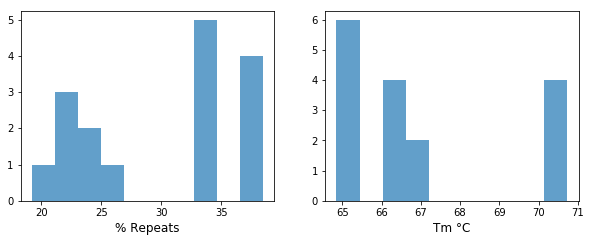

In [34]:
fig, ax = plt.subplots(1,2,figsize=(10,3.5),
                      sharey= False)
ax[0].hist(primersheet['% Repeats'], bins = 10, alpha = 0.7)
ax[0].set_xlabel('% Repeats', size = 12)
ax[1].hist(primersheet['Tm °C'], bins = 10, alpha = 0.7)
ax[1].set_xlabel('Tm °C', size = 12)


plt.show()

In [234]:
primersheet.to_clipboard(sep = '\t')

In [180]:
primersheet.drop_duplicates('Primer').reset_index(drop = True)

,Source,Target,Primer,Tm °C,GC,% Repeats
0,4DUF,4DUE,CAAacacttaagccggaaggctttgtagttaaagca,61.984101,41.666667,33.333333
1,4DUE,4DUF,CTAacacttaagccggaaggctttgtagttaaagca,61.984101,41.666667,30.555556
2,4HGG,4HGF,AAAatgaataaactgcagcgtgccaacccggatgatccggcgtatg...,71.697039,48.076923,23.076923
3,4HGF,4HGG,AGAatgaataaactgcagcgtgccaacccggatgatccggcgtatg...,71.697039,50.000000,19.230769
4,4HGF,4HGH,GCAatgaataaactgcagcgtgccaacccggatgatccggcgtatg...,71.697039,51.923077,19.230769
5,4ZFA,5JQ2,TGCcatgaggccacattagtccttggcatgatgctgaagcattttg...,68.252900,46.153846,23.076923
6,2UWH,4KEY,GTAacttcatggacccatgaaaaaaattggaaaaaggcccacaata...,65.834509,36.538462,44.230769
7,4HGH,2X7Y,ACAcatatgcttaatggcaaagacccggagaccggggagcctcttg...,70.785344,51.923077,26.923077
8,4ZFA,1SMJ,GAAggtcatgaaacgacctcggggctgctgagcttcgcgctgtact...,74.017839,57.692308,23.076923
9,4KEY,2UWH,TTCacttcatggacccatgaaaaaaattggaaaaaggcccacaata...,65.834509,36.538462,46.153846


In [182]:
len(G.nodes)

19